<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_abc/blob/main/PIFWIA_ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ABC - Artificial Bee Colony ou Colônia Artificial de Abelhas é uma metaheurística proposta pelo pesquisador Derviş Karaboğa em 2005 para resolver problemas de otimização inspirado no comportamento do forrageamento inteligente das abelhas, buscando melhorar a solução candidata em relação a um objetivo.

Karaboga, D. An Idea Based on Honey Bee Swarm for Numerical Optimization Artificial Intelligence Research at the University of Bologna. http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.714.4934, 2005.

In [ ]:
#instala biblioteca Orange Canvas
!pip install Orange3

In [ ]:
#importa bibliotecas
import Orange
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from numpy.random import choice
from sklearn import metrics

In [ ]:
#define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos defindo quantas explorações serão feitas (episódios)
ENXAME = 40 #tamanho da população correspondente ao número de abelhas na colônia
FONTES_ALIMENTACAO = int(ENXAME/2) #(nf) número de fontes de alimento que a colônia irá explorar (i.e., qtde de abelhas exploradoras) que é a metade da qtde de abelhas trabalhadoras
E1 = -15 #extremo esquerdo eixo x
E2 = 15 #extremo direito eixo x
E3 = -100 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E3,E4] #(bound) determina os valores mínimos e máximos do espaço de busca
FCUSTO = 'rosenbrock' #(fitness) define a aptidão da abelha na possível solução do problema
CICLOS = 10 #(limite) qtde de ciclos sem melhora na exploração de uma fonte de alimento utilizado para abandonar essa exploração e buscar outras fontes aleatoriamente
ABELHAS = [] #(swarm) array da criação das abelhas

In [ ]:
#importa dados
from google.colab import files  
files.upload()

In [ ]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/dados.csv")

In [ ]:
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #explora os domínios dos atributos (campos da base de dados)
print("Qtde de Registros:", len(dados)) #explora os dados (quantidade de registros da base de dados)
i = 0 #exibe os primeiros registros para análise dos dados importados
for d in dados[:20]:
  i += 1
  print(i, d)

7 metadados: 7 continuos, 0 discretos
Nome dos metadados: PROCESSO, ANO, COMPLEXIDADE, PAGINA, PRAZO, REVISOES, ENTREGA
Qtde de Registros: 1013
1 [2022000101, 2019, 3, 12, 10, 4, 36]
2 [2022000102, 2020, 3, 20, 10, 4, 36]
3 [2022000103, 2020, 3, 55, 15, 5, 70]
4 [2022000104, 2018, 4, 43, 10, 4, 36]
5 [2022000105, 2018, 2, 24, 10, 4, 36]
6 [2022000106, 2019, 1, 93, 15, 3, 42]
7 [2022000107, 2018, 3, 44, 10, 5, 45]
8 [2022000108, 2020, 2, 37, 10, 5, 45]
9 [2022000109, 2020, 1, 11, 10, 2, 18]
10 [2022000110, 2019, 1, 10, 5, 2, 8]
11 [2022000111, 2020, 2, 32, 10, 5, 45]
12 [2022000112, 2019, 2, 13, 10, 3, 27]
13 [2022000113, 2020, 1, 14, 10, 2, 18]
14 [2022000114, 2020, 3, 51, 15, 1, 14]
15 [2022000115, 2019, 4, 8, 5, 1, 4]
16 [2022000116, 2020, 3, 82, 15, 2, 28]
17 [2022000117, 2020, 2, 12, 10, 3, 27]
18 [2022000118, 2018, 2, 16, 10, 2, 18]
19 [2022000119, 2018, 2, 97, 15, 5, 70]
20 [2022000120, 2018, 4, 87, 15, 5, 70]


In [ ]:
#cria arrays das dimensões do problema a ser otimizado
periodo = []
complexidade = [] #1-muito baixa complexidade;2-baixa complexidade;3-média complexidade;4-alta complexidade;e,5-muito alta complexidade
pagina = []
prazo = []
revisao = []
entrega = []
i = 0
for d in dados[:ENXAME]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  print("id:",i,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])
  i += 1

id: 0 período: 2019 complexidade: 3 página: 12 prazo: 10 revisões: 4 entrega: 36
id: 1 período: 2020 complexidade: 3 página: 20 prazo: 10 revisões: 4 entrega: 36
id: 2 período: 2020 complexidade: 3 página: 55 prazo: 15 revisões: 5 entrega: 70
id: 3 período: 2018 complexidade: 4 página: 43 prazo: 10 revisões: 4 entrega: 36
id: 4 período: 2018 complexidade: 2 página: 24 prazo: 10 revisões: 4 entrega: 36
id: 5 período: 2019 complexidade: 1 página: 93 prazo: 15 revisões: 3 entrega: 42
id: 6 período: 2018 complexidade: 3 página: 44 prazo: 10 revisões: 5 entrega: 45
id: 7 período: 2020 complexidade: 2 página: 37 prazo: 10 revisões: 5 entrega: 45
id: 8 período: 2020 complexidade: 1 página: 11 prazo: 10 revisões: 2 entrega: 18
id: 9 período: 2019 complexidade: 1 página: 10 prazo: 5 revisões: 2 entrega: 8
id: 10 período: 2020 complexidade: 2 página: 32 prazo: 10 revisões: 5 entrega: 45
id: 11 período: 2019 complexidade: 2 página: 13 prazo: 10 revisões: 3 entrega: 27
id: 12 período: 2020 complex

In [ ]:
#função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fcusto(problema, possivel_solucao, alfa=0, beta=0, gama=0, delta=0, epsilon=0, zeta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(possivel_solucao[i+1] - possivel_solucao[i]**2)**2 + (1-possivel_solucao[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += possivel_solucao[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in possivel_solucao]))
  elif problema == 'caminho':
    denominador = sum([(caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta for caminho in possivel_solucao])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(possivel_solucao)  for _ in possivel_solucao]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta) / denominador for caminho in possivel_solucao]
    total = choice(possivel_solucao, 1, p=distribuicao_probabilidades)[0]
  elif problema == "distância":
    total = 0
    pontos = []
    for i in range(ENXAME): 
      if i < ENXAME - 1:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[i+1]])
      else:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[0]])
    total = 1/total
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#abelha - unidade base da otimização, posicionada numa determinada posição no espaço de busca do problema, representando uma solução em potencial para o problema
class Exploradora: #(exploration) responsáveis por sair da colméia em busca de uma fonte de alimento para que de posse da informação da qualidade da fonte (fitness) retornam para repassar a informação
  def __init__(self):
        self.posicao = None
        self.trabalhadoras = []
        self.ciclos_sem_melhora = 0
class Trabalhadora: #(exploitation) escolhem uma fonte de alimento para explorar de acordo com seu fitness, sendo as responsáveis por explorar a vizinhança de uma fonte de alimento
  def __init__(self):
        self.posicao = None

In [ ]:
#calcula escolha das fontes de alimento
def alocar_abelhas(abelhas):
  #faz a soma dos fitness das abelhas exploradoras
  soma_fitness = 0
  for i in range(FONTES_ALIMENTACAO):
    soma_fitness += fcusto(FCUSTO, exploradoras[i].posicao)
  #cria a distribuição de probabilidades de acordo com o fitness calculado
  distribuicao_probabilidade = []
  for i in range(FONTES_ALIMENTACAO):
    probabilidade_alocacao = fcusto(FCUSTO, exploradoras[i].posicao) / soma_fitness
    distribuicao_probabilidade.append(probabilidade_alocacao)
  #posiciona as oportunitas de acordo com a atratividade das exploradoras, "transformando-as" agora em trabalhadoras
  for abelha in abelhas:
    exploradora = choice(exploradoras, 1, p=distribuicao_probabilidade)[0]
    abelha.posicao = exploradora.posicao.copy()
    exploradora.trabalhadoras.append(abelha)

In [ ]:
#calcula movimento da abelha exploradora
def movimenta_abelha(abelha):
  colonia_candidata = ABELHAS.copy()
  colonia_candidata.remove(abelha)
  abelha_candidata = random.choice(colonia_candidata)
  x = abelha.posicao[0] + random.uniform(-1, 1) * (abelha.posicao[0] - abelha_candidata.posicao[0])
  y = abelha.posicao[1] + random.uniform(-1, 1) * (abelha.posicao[1] - abelha_candidata.posicao[1])
  if x < -10:
    x = -10
  elif x > 10:
    x = 10
  if y < -10:
    y = -10
  elif y > 10:
    y = 10
  if fcusto(FCUSTO, [x, y]) > fcusto(FCUSTO, abelha.posicao):
    abelha.posicao = [x, y]

In [ ]:
#plota posições no gráfico
def exibe_grafico(titulo,x,y):
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, color='b')
  plt.title(titulo)
  for i in range(FONTES_ALIMENTACAO):
    plt.plot(x[i],y[i],marker='o')
  plt.show()

In [ ]:
#inicializa população (enxame)
exploradoras = []
trabalhadoras = []
for i in range(FONTES_ALIMENTACAO):
  cpx = complexidade[i]
  pag = pagina[i]
  exploradora = Exploradora()
  exploradora.posicao = [cpx,pag] #[random.uniform(E1,E2), random.uniform(E1,E2)]
  exploradora.melhor_posicao = exploradora.posicao.copy()
  exploradoras.append(exploradora)
  trabalhadora = Trabalhadora()
  trabalhadoras.append(trabalhadora)
ABELHAS = exploradoras + trabalhadoras
#for i in range(FONTES_ALIMENTACAO): print("i:",i) print(list(ABELHAS[i].posicao)) print(list(ABELHAS[i].melhor_posicao))

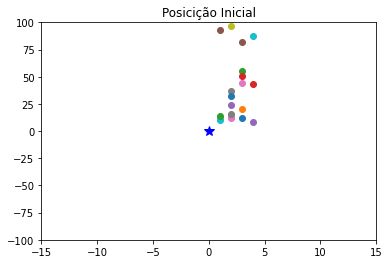

In [ ]:
#posiciona as abelhas exploradoras no espaço de busca
x = []
y = []
for i in range(FONTES_ALIMENTACAO):
    abelha = exploradoras[i]
    d1,d2 = zip(abelha.posicao)
    x.append(d1)
    y.append(d2)
exibe_grafico('Posicição Inicial',x,y)

Iteração: 44


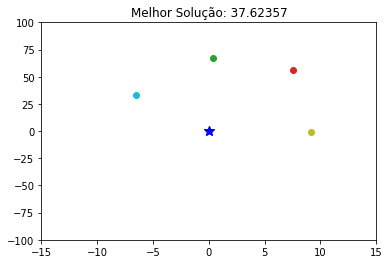

Iteração: 45


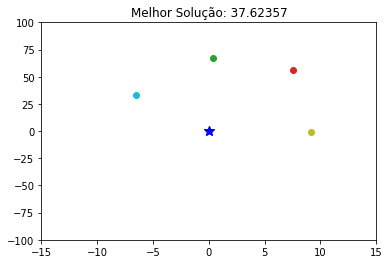

Iteração: 46


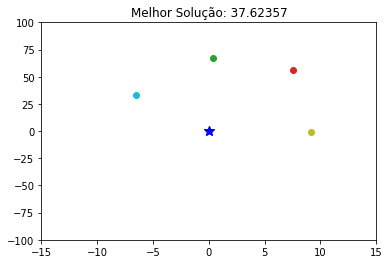

Iteração: 47


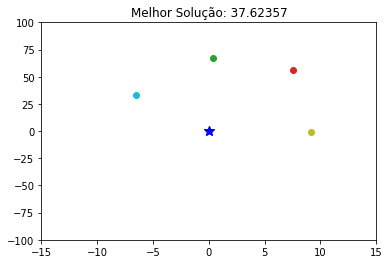

Iteração: 48


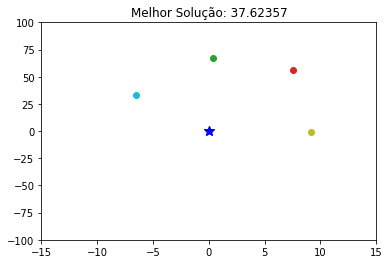

Iteração: 49


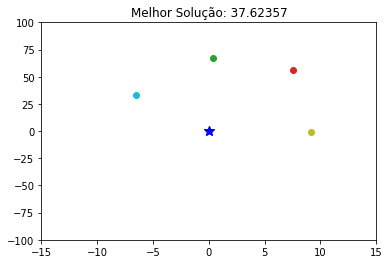

Iteração: 50


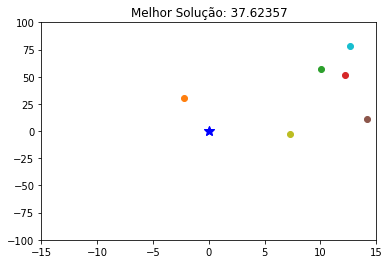

Iteração: 51


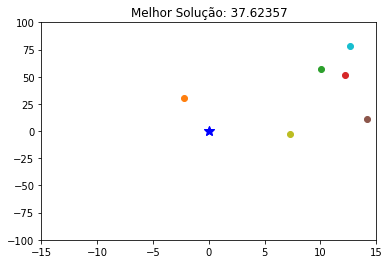

Iteração: 52


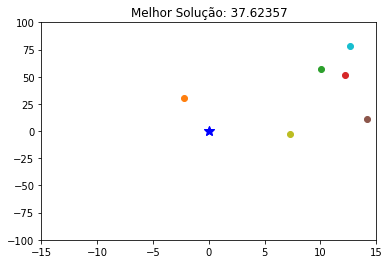

Iteração: 53


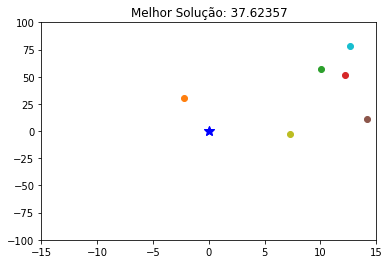

Iteração: 54


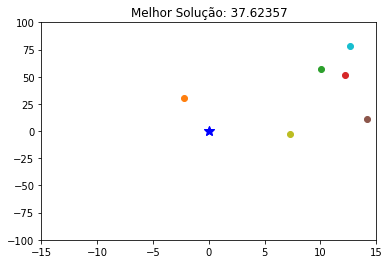

Iteração: 55


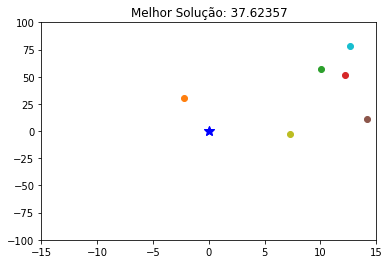

Iteração: 56


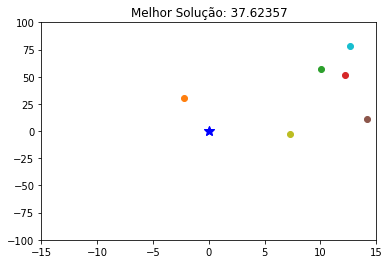

Iteração: 57


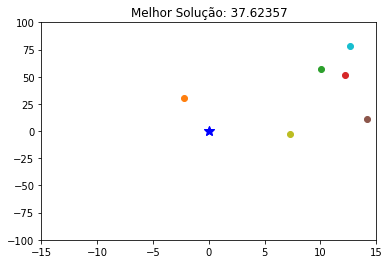

Iteração: 58


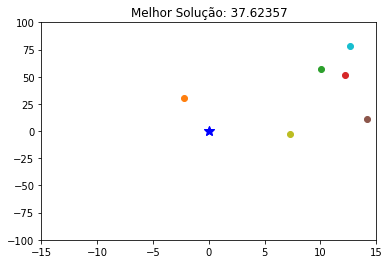

Iteração: 59


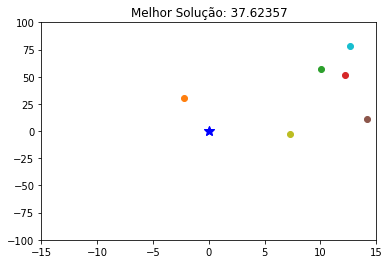

Iteração: 60


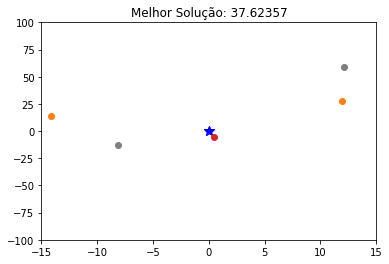

Iteração: 61


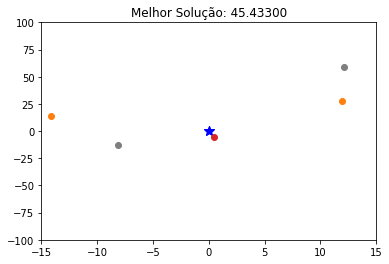

Iteração: 62


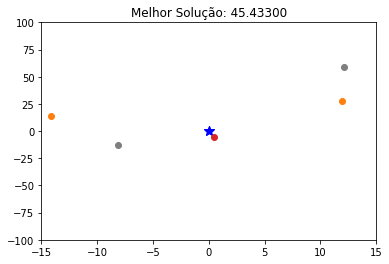

Iteração: 63


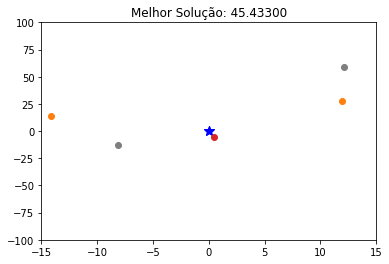

Iteração: 64


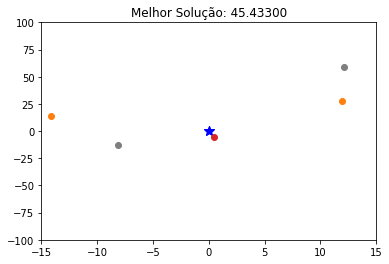

Iteração: 65


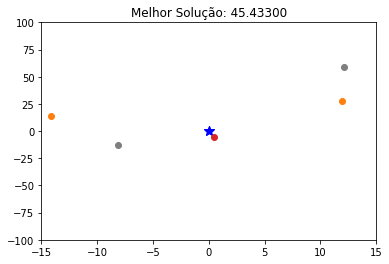

Iteração: 66


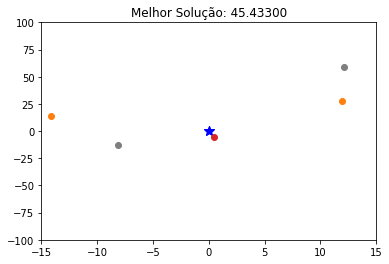

Iteração: 67


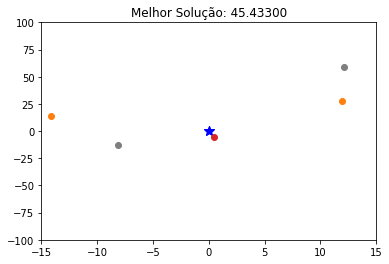

Iteração: 68


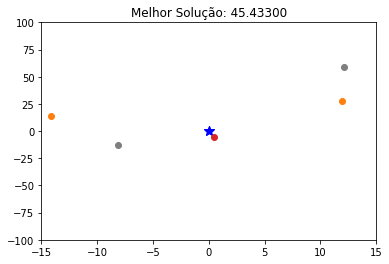

Iteração: 69


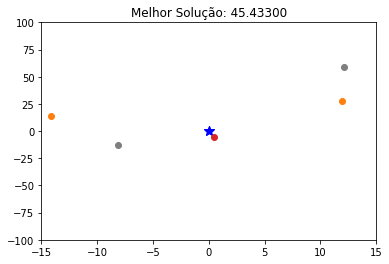

Iteração: 70


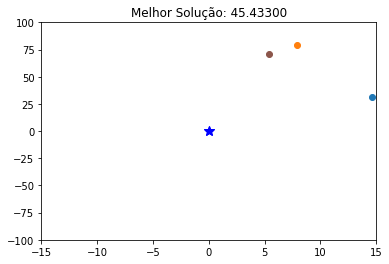

Iteração: 71


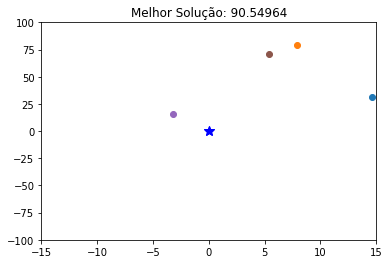

Iteração: 72


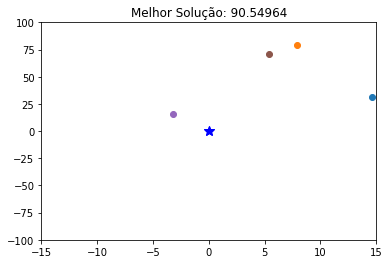

Iteração: 73


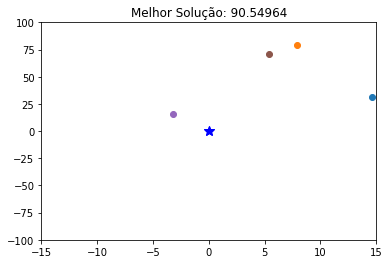

Iteração: 74


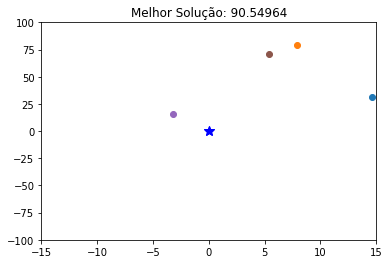

Iteração: 75


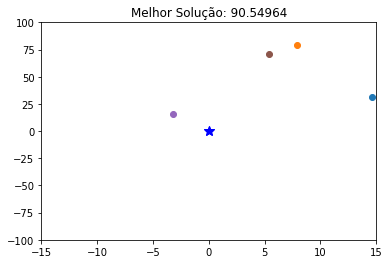

Iteração: 76


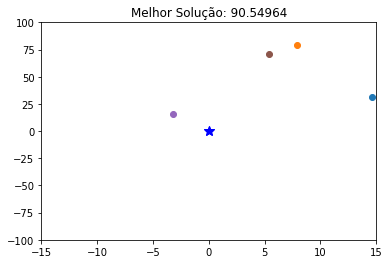

Iteração: 77


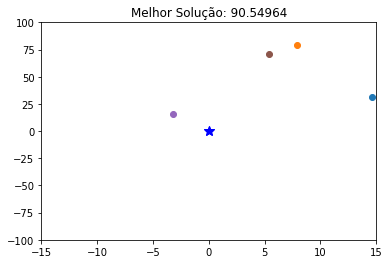

Iteração: 78


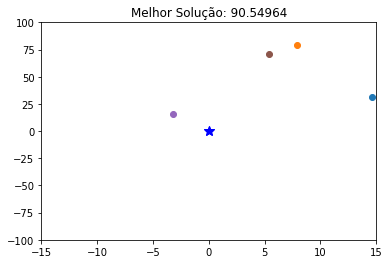

Iteração: 79


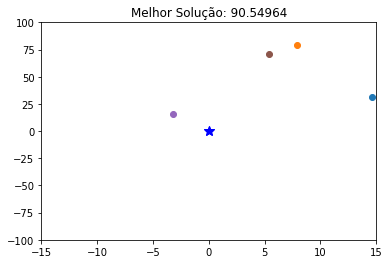

Iteração: 80


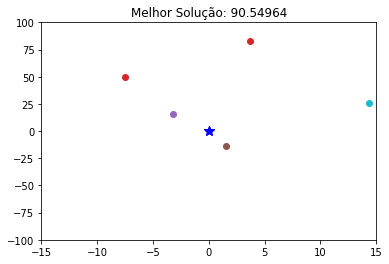

Iteração: 81


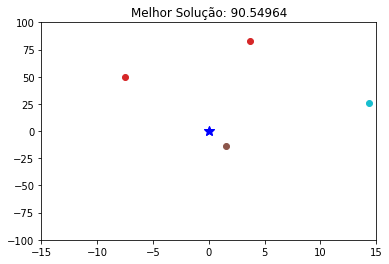

Iteração: 82


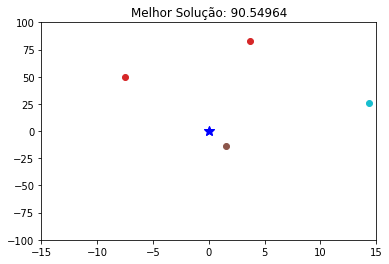

Iteração: 83


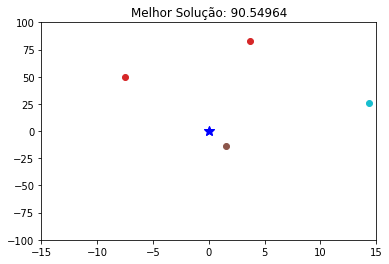

Iteração: 84


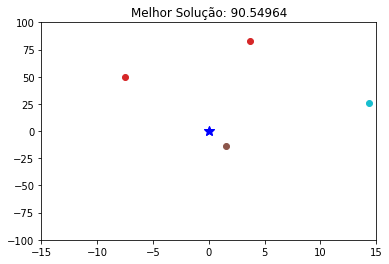

Iteração: 85


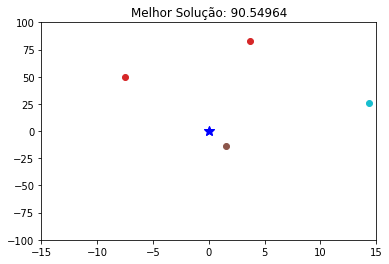

Iteração: 86


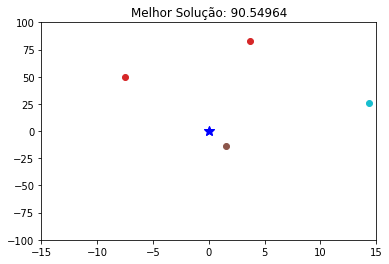

Iteração: 87


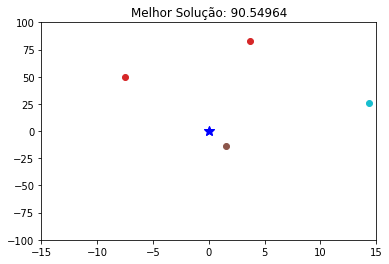

Iteração: 88


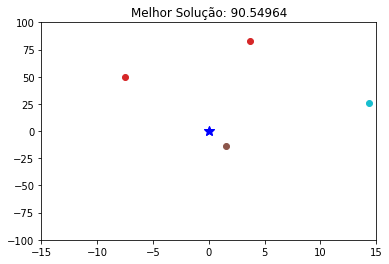

Iteração: 89


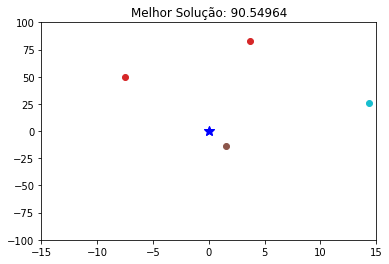

Iteração: 90


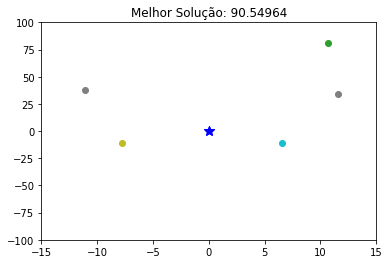

Iteração: 91


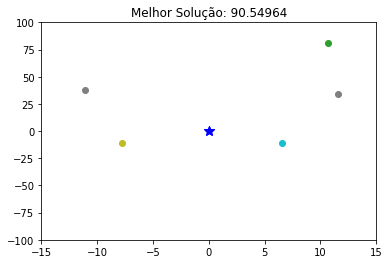

Iteração: 92


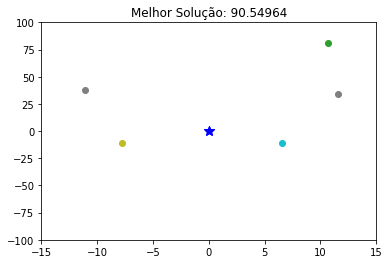

Iteração: 93


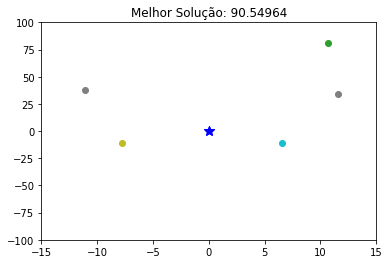

Iteração: 94


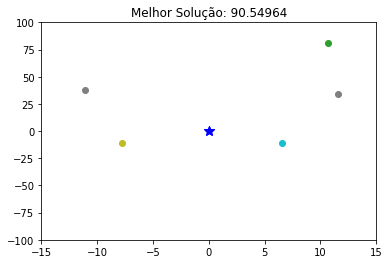

Iteração: 95


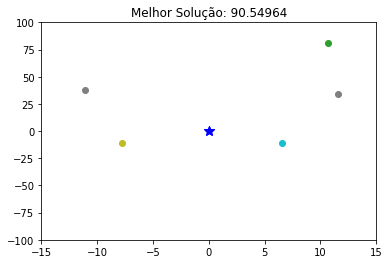

Iteração: 96


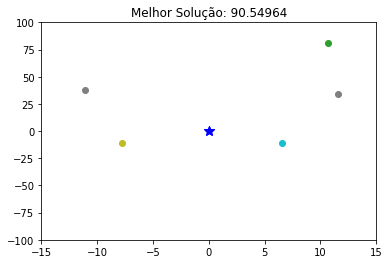

Iteração: 97


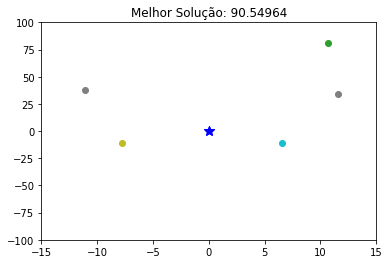

Iteração: 98


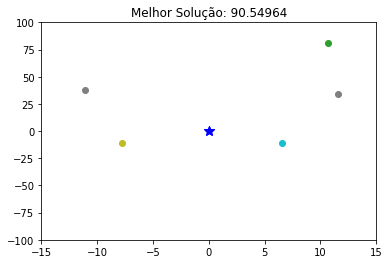

Iteração: 99


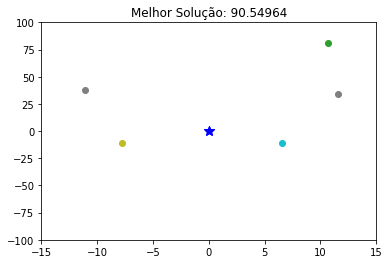

Iteração: 100


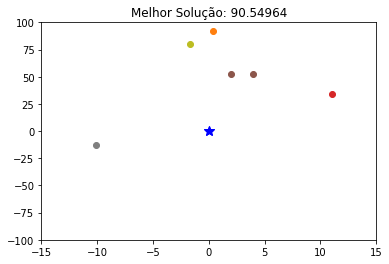

Iteração: 101


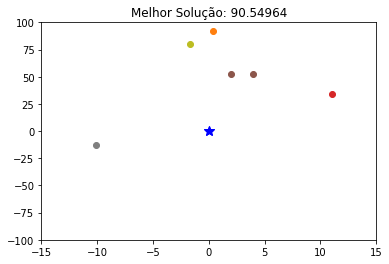

Iteração: 102


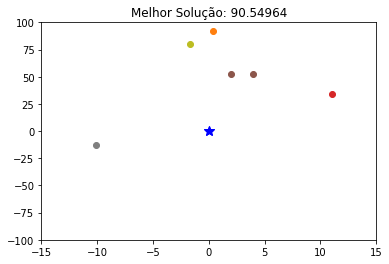

Iteração: 103


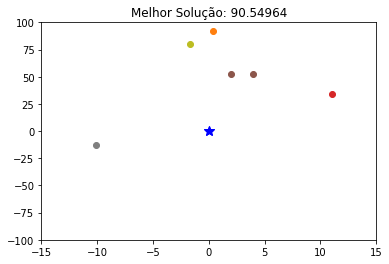

Iteração: 104


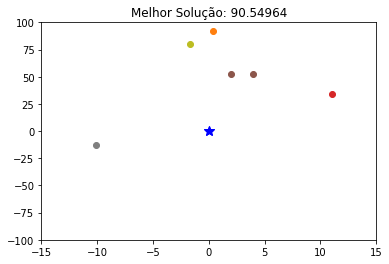

Iteração: 105


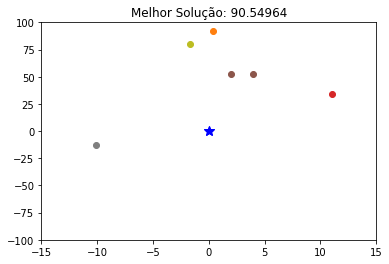

Iteração: 106


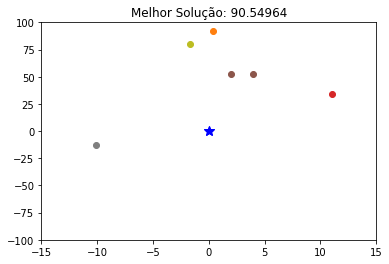

Iteração: 107


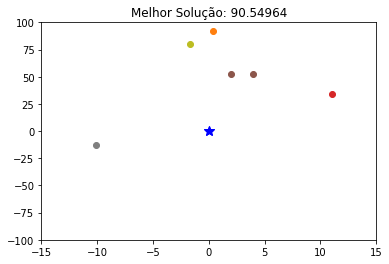

Iteração: 108


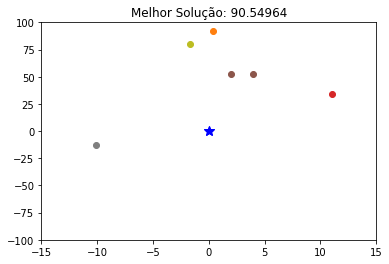

Iteração: 109


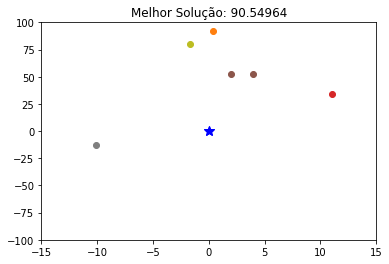

Iteração: 110


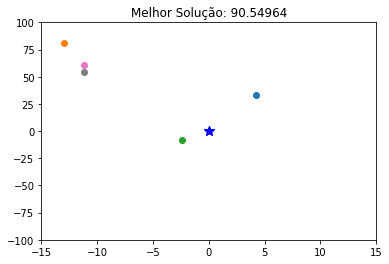

Iteração: 111


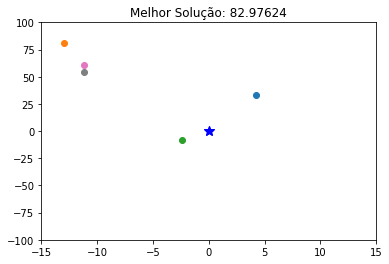

Iteração: 112


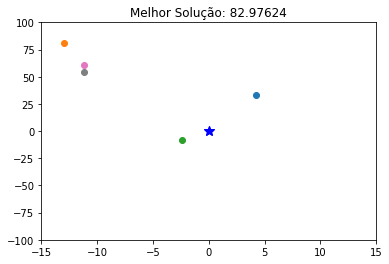

Iteração: 113


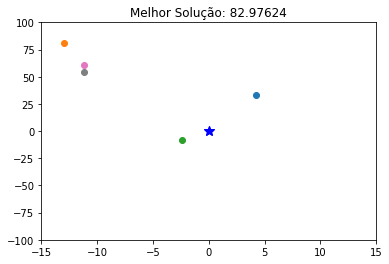

Iteração: 114


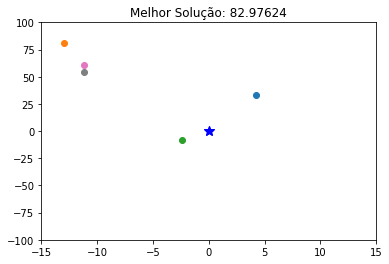

Iteração: 115


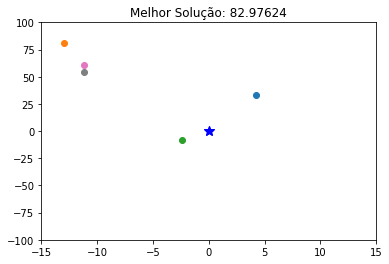

Iteração: 116


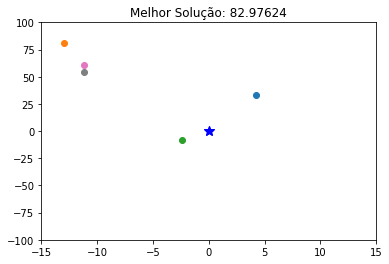

Iteração: 117


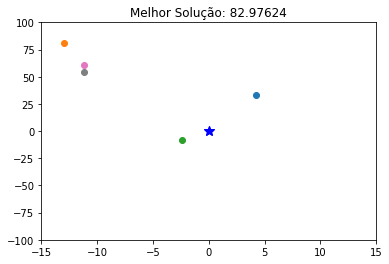

Iteração: 118


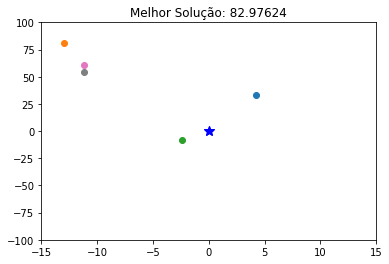

Iteração: 119


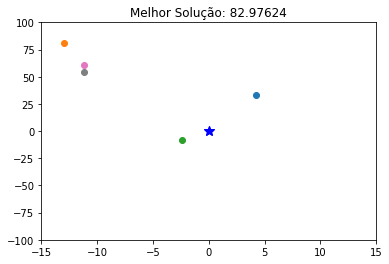

Iteração: 120


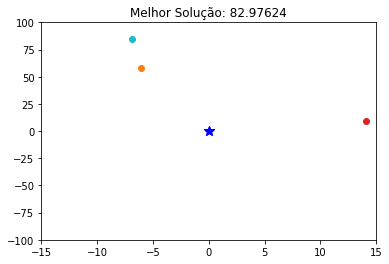

Iteração: 121


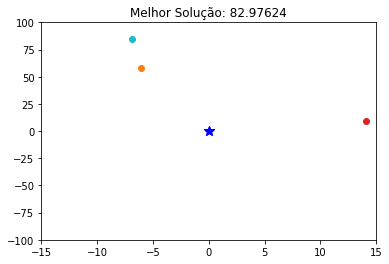

Iteração: 122


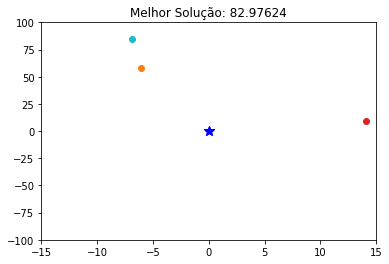

Iteração: 123


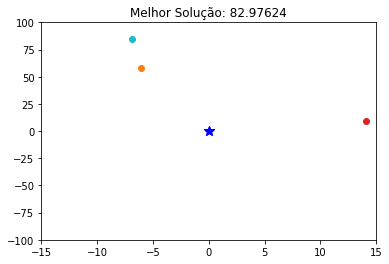

Iteração: 124


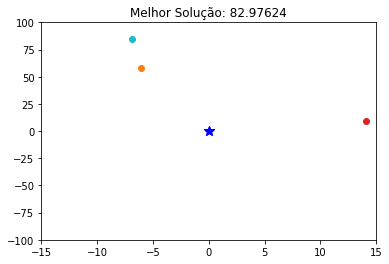

Iteração: 125


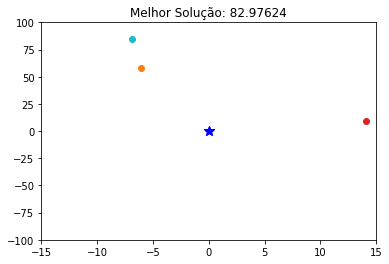

Iteração: 126


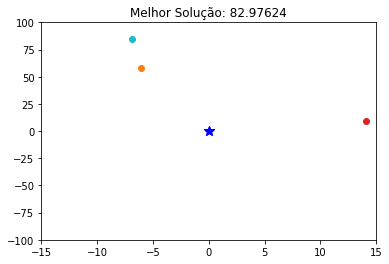

Iteração: 127


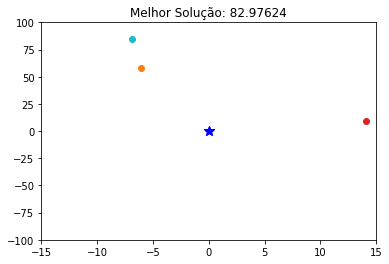

Iteração: 128


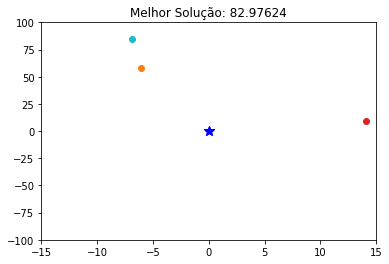

Iteração: 129


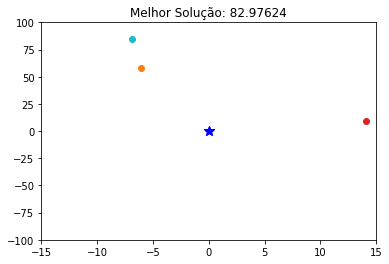

Iteração: 130


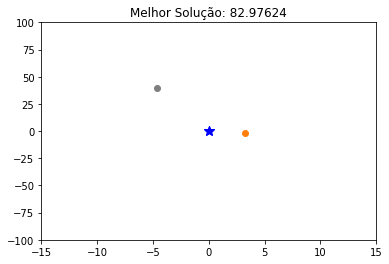

Iteração: 131


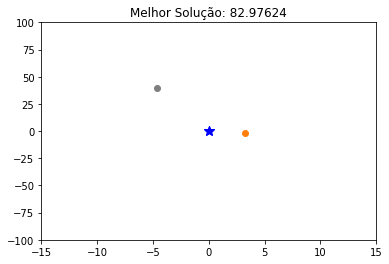

Iteração: 132


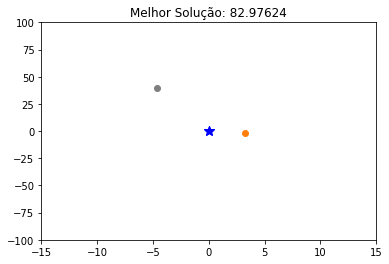

Iteração: 133


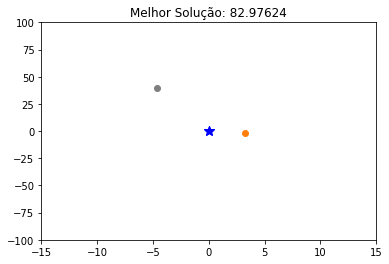

Iteração: 134


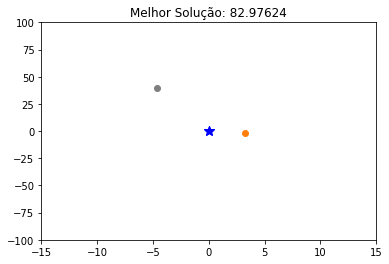

Iteração: 135


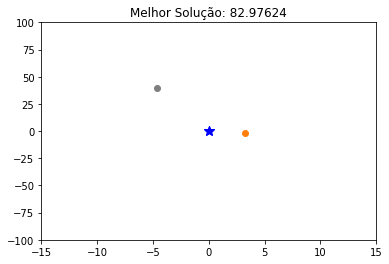

Iteração: 136


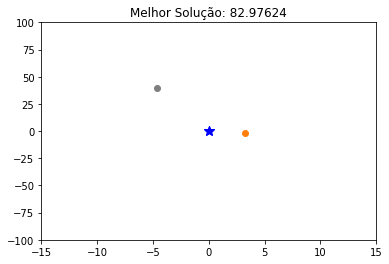

Iteração: 137


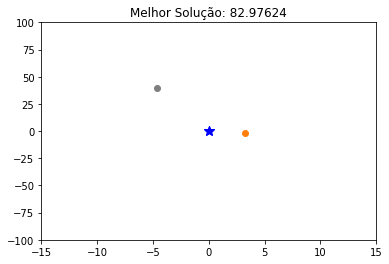

Iteração: 138


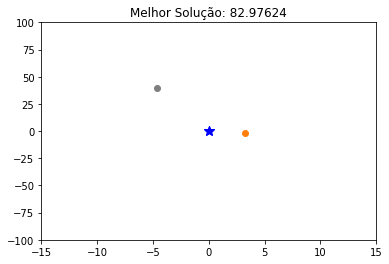

Iteração: 139


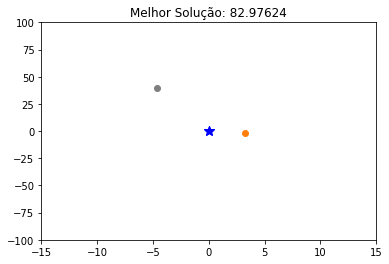

Iteração: 140


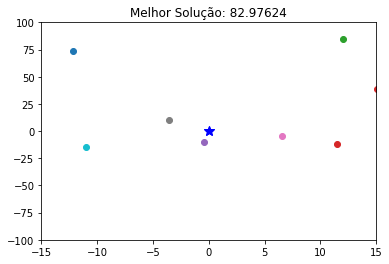

Iteração: 141


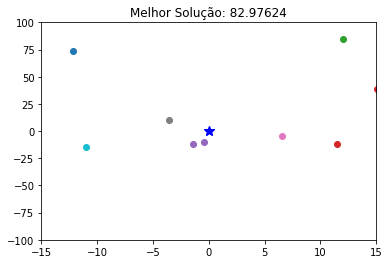

Iteração: 142


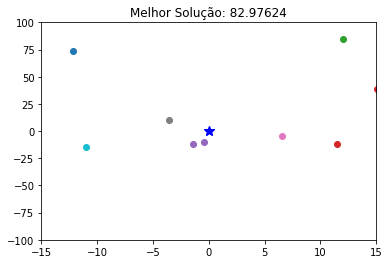

Iteração: 143


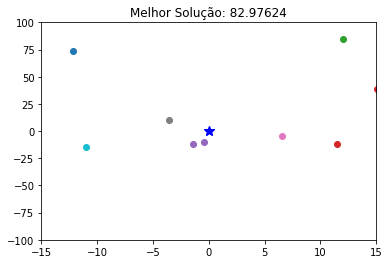

Iteração: 144


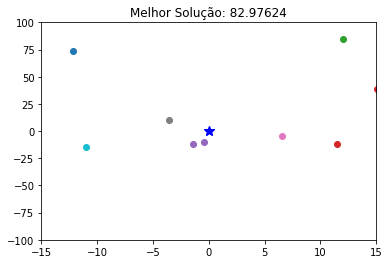

Iteração: 145


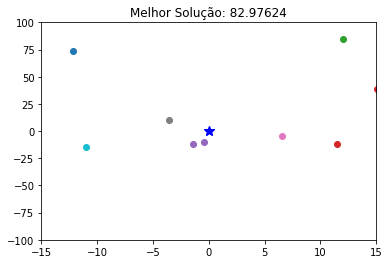

Iteração: 146


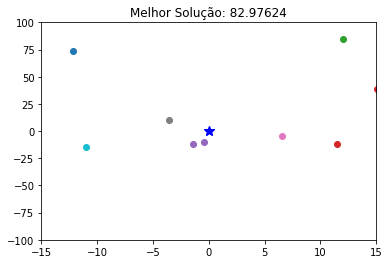

Iteração: 147


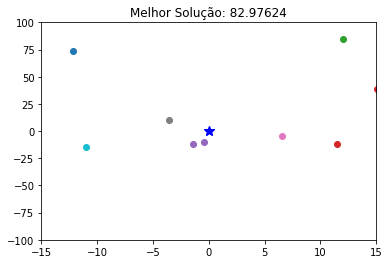

Iteração: 148


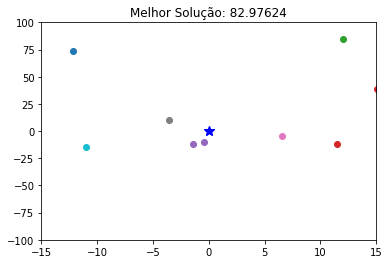

Iteração: 149


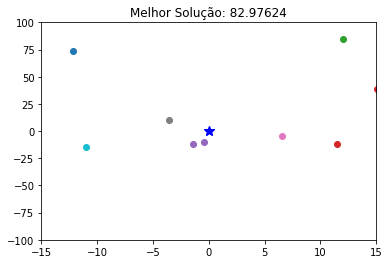

Iteração: 150


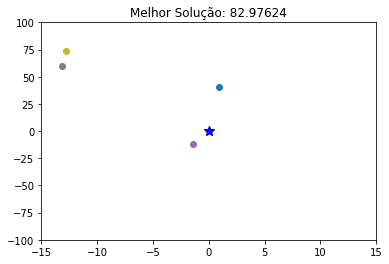

Iteração: 151


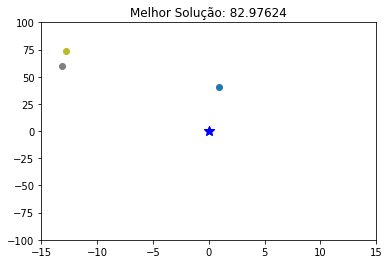

Iteração: 152


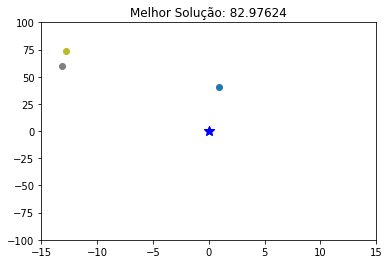

Iteração: 153


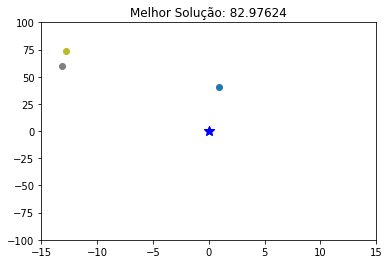

Iteração: 154


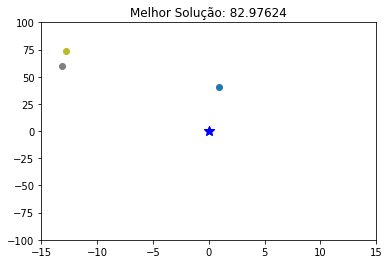

Iteração: 155


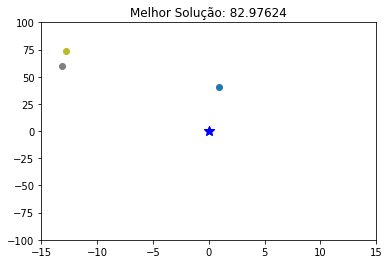

Iteração: 156


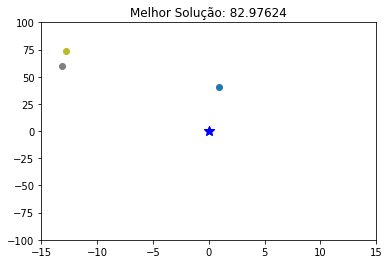

Iteração: 157


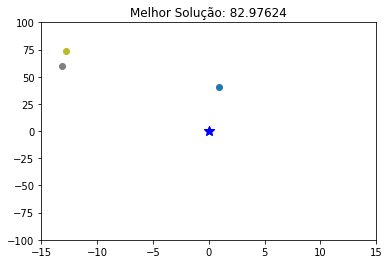

Iteração: 158


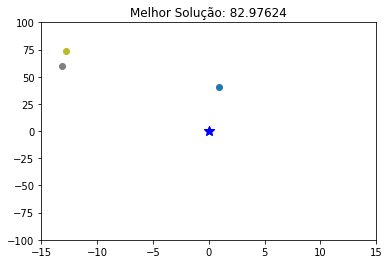

Iteração: 159


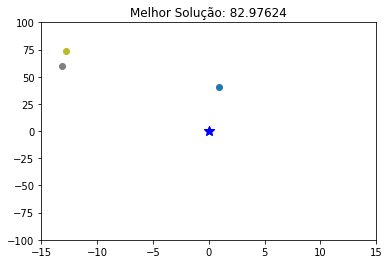

Iteração: 160


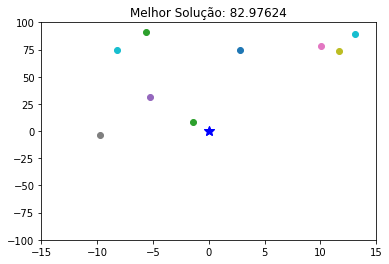

Iteração: 161


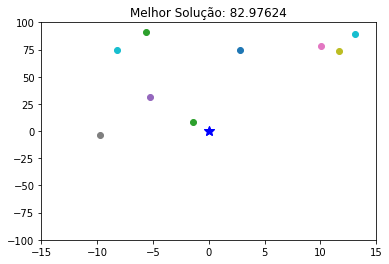

Iteração: 162


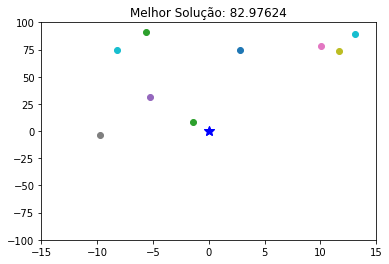

Iteração: 163


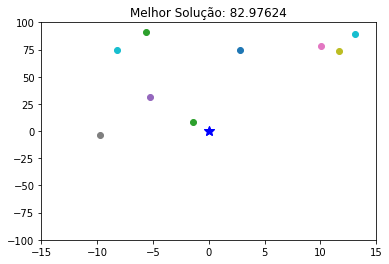

Iteração: 164


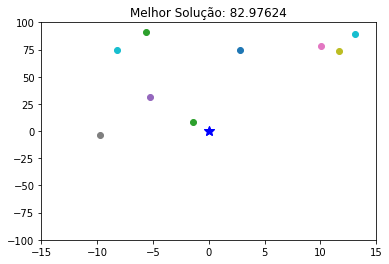

Iteração: 165


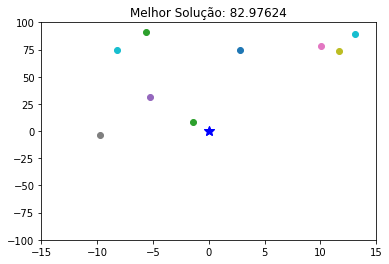

Iteração: 166


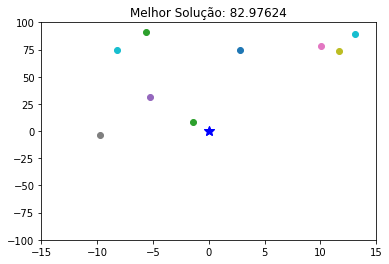

Iteração: 167


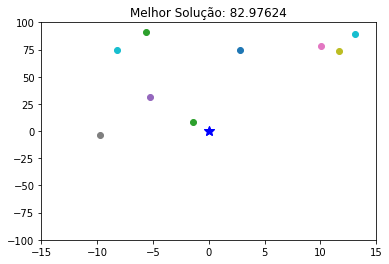

Iteração: 168


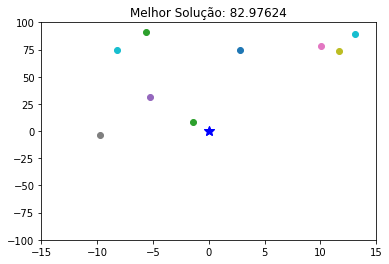

Iteração: 169


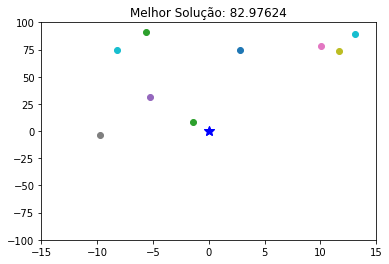

Iteração: 170


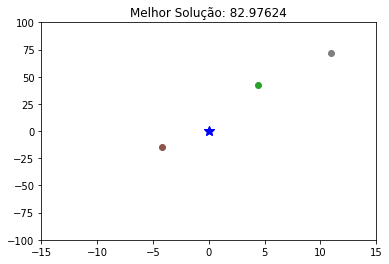

Iteração: 171


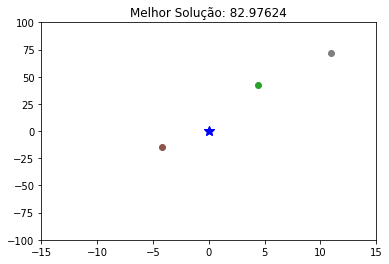

Iteração: 172


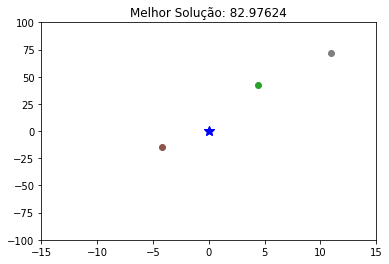

Iteração: 173


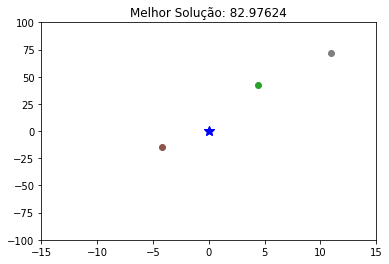

Iteração: 174


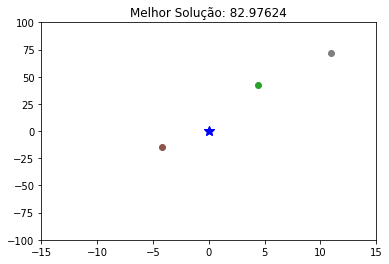

Iteração: 175


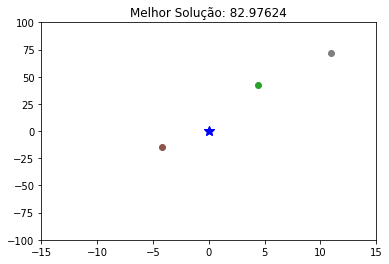

Iteração: 176


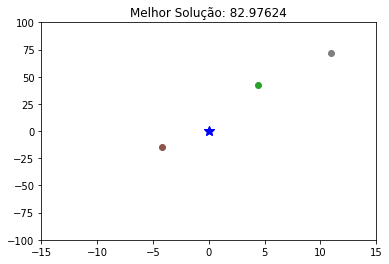

Iteração: 177


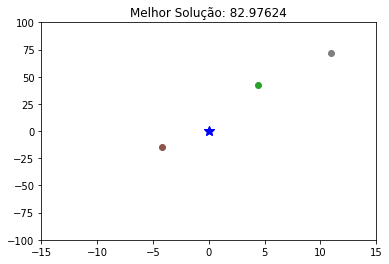

Iteração: 178


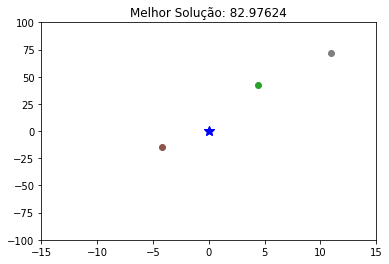

Iteração: 179


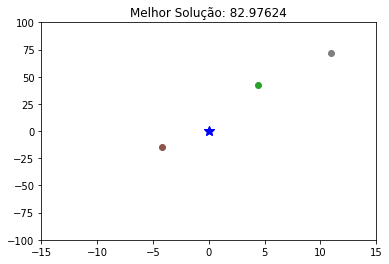

Iteração: 180


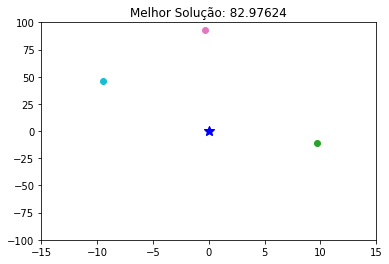

Iteração: 181


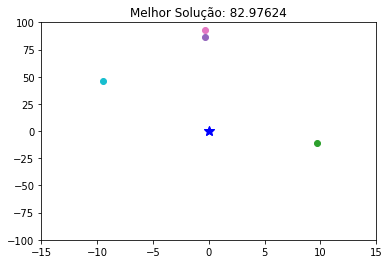

Iteração: 182


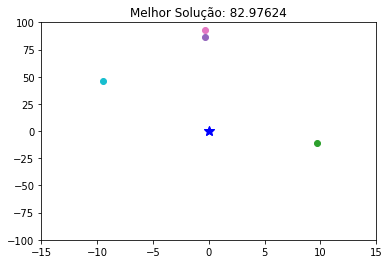

Iteração: 183


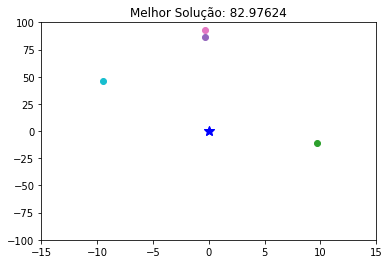

Iteração: 184


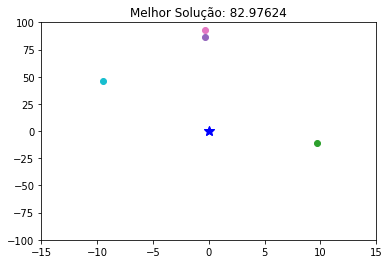

Iteração: 185


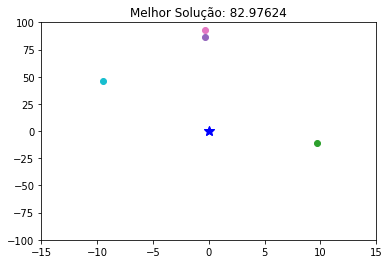

Iteração: 186


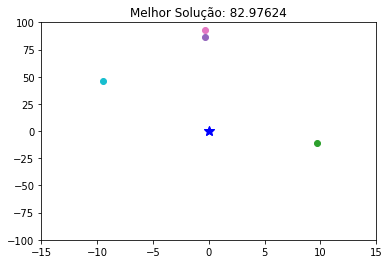

Iteração: 187


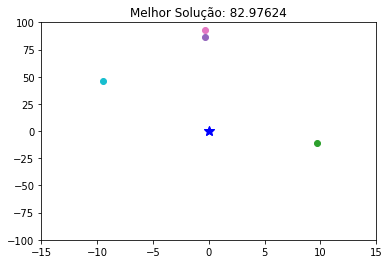

Iteração: 188


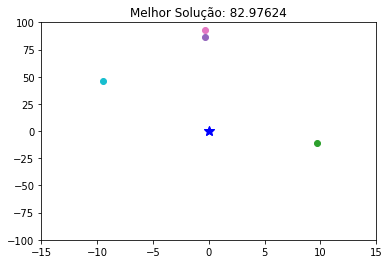

Iteração: 189


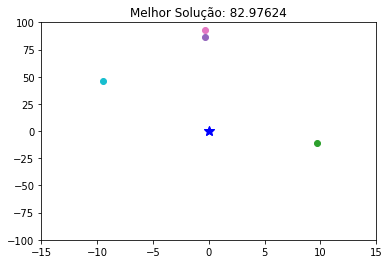

Iteração: 190


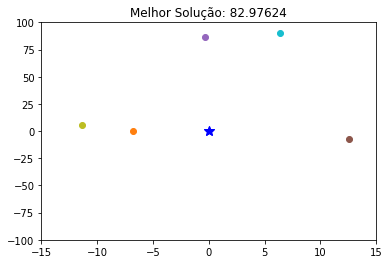

Iteração: 191


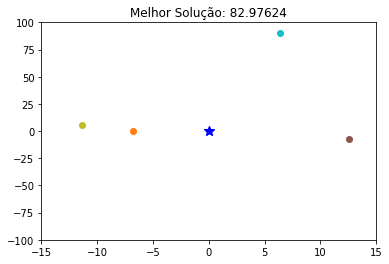

Iteração: 192


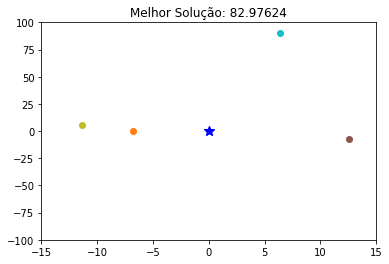

Iteração: 193


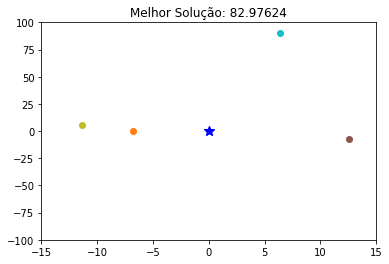

Iteração: 194


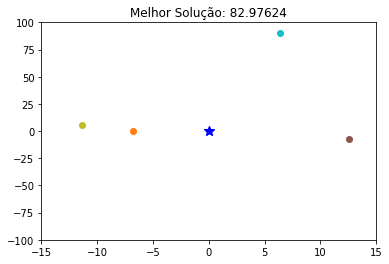

Iteração: 195


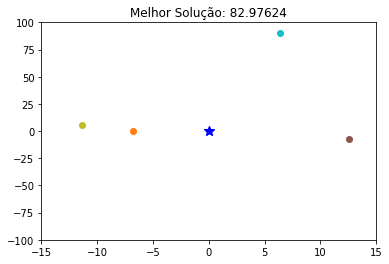

Iteração: 196


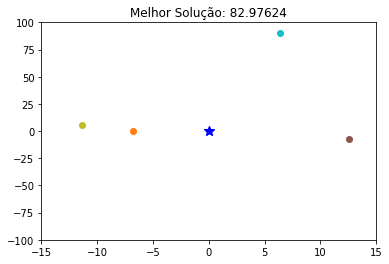

Iteração: 197


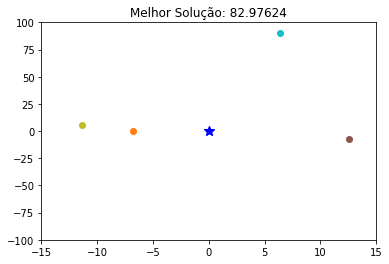

Iteração: 198


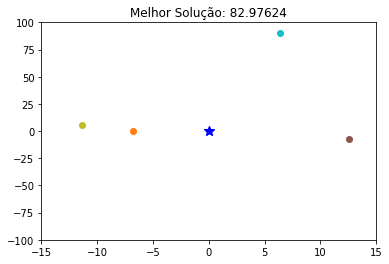

Iteração: 199


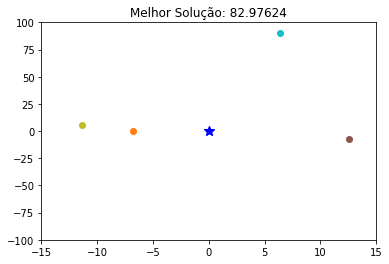

Iteração: 200


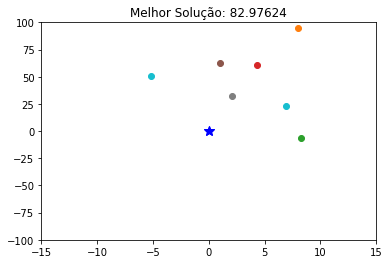

In [ ]:
#otimização ABC
melhor_posicao = None
ciclo = 0
#alocando as abelhas oportunistas como trabalhadoras em suas fontes
alocar_abelhas(trabalhadoras)
lista_melhores_valores = []
convergencia = []
while ciclo < ITERACOES:
  print("Iteração: {:.0f}".format(ciclo+1))
  ciclo += 1
  for exploradora in exploradoras:
    #movimentando as trabalhadoras de cada fonte de comida
    for trabalhadora in exploradora.trabalhadoras:
      movimenta_abelha(trabalhadora)
    #obtem a melhor posição da iteração
    melhor_posicao_iter = None
    if len(exploradora.trabalhadoras) == 0:
      melhor_posicao_iter = exploradora.posicao
    for trabalhadora in exploradora.trabalhadoras:
      if melhor_posicao_iter is None or fcusto(FCUSTO, trabalhadora.posicao) > fcusto(FCUSTO, melhor_posicao_iter):
        melhor_posicao_iter = trabalhadora.posicao.copy()
    #atualiza posição atual da abelha exploradora
    if melhor_posicao_iter is not None and fcusto(FCUSTO, melhor_posicao_iter) > fcusto(FCUSTO, exploradora.posicao):
      exploradora.posicao = melhor_posicao_iter.copy()
      exploradora.ciclos_sem_melhora = 0
    else:
      exploradora.ciclos_sem_melhora += 1
    #desfaz a exploração da fonte de comida se necessário
    if exploradora.ciclos_sem_melhora >= CICLOS:
      exploradora.posicao = [random.uniform(E1, E4), random.uniform(E1, E4)] #[random.uniform(-10, 10), random.uniform(-10, 10)]
      exploradora.melhor_posicao = exploradora.posicao.copy()
      exploradora.ciclos_sem_melhora = 0
      trabalhadoras_desalocadas = exploradora.trabalhadoras
      exploradora.trabalhadoras = []
      alocar_abelhas(trabalhadoras_desalocadas)
    #atuaiza melhor posicao global
    if melhor_posicao is None or fcusto(FCUSTO, melhor_posicao_iter) > fcusto(FCUSTO, melhor_posicao):
      melhor_posicao = melhor_posicao_iter.copy()
    lista_melhores_valores.append(melhor_posicao)
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, color='b')
  #exibe o enxame - mostrando no gráfico as posições atuais de cada abelha exploradora
  x = []
  y = []
  for i in range(FONTES_ALIMENTACAO):
    exploradora = exploradoras[i]
    d1,d2 = zip(exploradora.posicao)
    x.append(d1)
    y.append(d2)
  exibe_grafico('Melhor Solução: {:.5f}'.format(melhor_posicao[1]),x,y)
  convergencia.append(melhor_posicao[1])

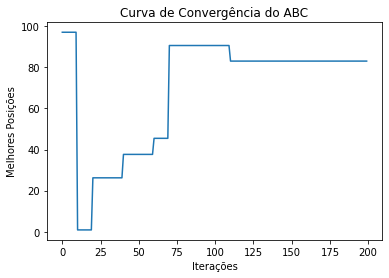

In [ ]:
#exibe curva de convergência das abelhas
x = []
y = []
for i in range(ITERACOES):
  x.append(i)
  y.append(convergencia[i])
plt.title("Curva de Convergência do ABC")
plt.xlabel("Iterações")
plt.ylabel("Melhores Posições")
plt.plot(x,y)
plt.show()
#for i in range(ITERACOES): print("iteração:",i,"posição:",convergencia[i])